In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [5]:
from fastai import *

In [3]:
bs = 64

In [6]:
path = untar_data(URLs.PETS) / 'images'

## Data Augmentation

In [7]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4,
                     max_warp=0.4, p_affine=1.0, p_lighting=1.0)

In [10]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=42)

In [12]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$').
            transform(tfms, size=size, padding_mode=padding_mode).
            databunch(bs=bs).normalize(imagenet_stats))

In [13]:
data = get_data(224, bs, 'zeros')

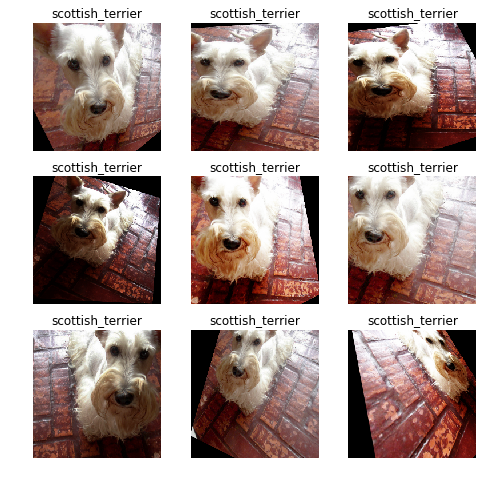

In [14]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8, 8))

In [15]:
data = get_data(224, bs)

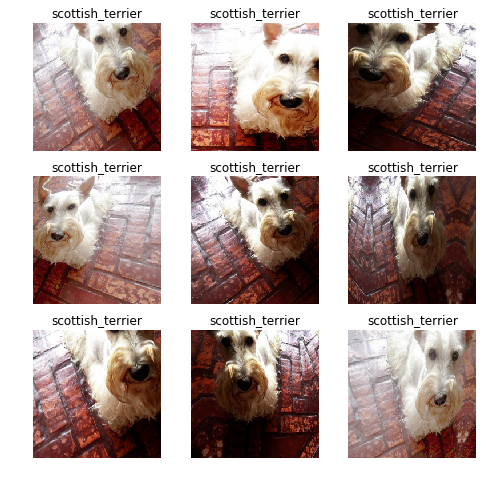

In [16]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

### Train Model

In [17]:
gc.collect()

29331

In [18]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [19]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch     train_loss  valid_loss  error_rate
1         2.617313    1.383541    0.277402    
2         1.581348    0.359580    0.085927    
3         0.967557    0.271522    0.069012    


In [20]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch     train_loss  valid_loss  error_rate
1         0.709367    0.296407    0.061570    
2         0.666951    0.292183    0.061570    


In [21]:
data = get_data(352, bs)
learn.data = data

In [22]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch     train_loss  valid_loss  error_rate
1         0.626360    0.269402    0.047361    
2         0.621956    0.261845    0.048038    


In [23]:
learn.save('352')

### Convolution Kernel

In [24]:
data = get_data(352, 16)

In [25]:
learn = create_cnn(data, models.resnet34, metrics=error_rate,
                  bn_final=True).load('352')

Category basset_hound

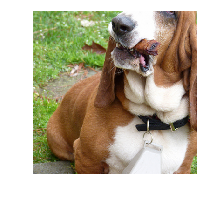

In [26]:
idx = 0
x, y = data.valid_ds[idx]
x.show()

data.valid_ds.y[idx]

In [27]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1]
]).expand(1, 3, 3, 3) / 6

In [30]:
from fastai.callbacks.hooks import *

In [31]:
k.shape

torch.Size([1, 3, 3, 3])

In [32]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [33]:
t[None].shape # np.expand_dims equivalent

torch.Size([1, 3, 352, 352])

In [34]:
## Shapes
## Input: (minibatch, channels, height, width)
## Kernel: (out_channels, in_channels*, height, width)
edge = F.conv2d(t[None], k)
## Output: (N, out_channels, height, width)

In [36]:
edge.shape

torch.Size([1, 1, 350, 350])

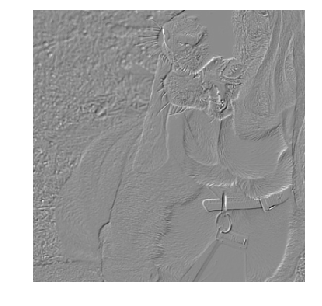

In [37]:
show_image(edge[0], figsize=(5, 5))

In [38]:
data.c

37

In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [40]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 176, 176]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 176, 176]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 176, 176]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 88, 88]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 88, 88]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 88, 88]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 88, 88]     0          False     
______________________________________________________________

## Heatmap

In [41]:
m = learn.model.eval()

In [42]:
xb, _ = data.one_item(x)

In [43]:
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [44]:
from fastai.callbacks.hooks import *

In [45]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [46]:
hook_a, hook_g = hooked_backward()

In [47]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [48]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [49]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 352, 352, 0),
             interpolation='bilinear', cmap='magma')

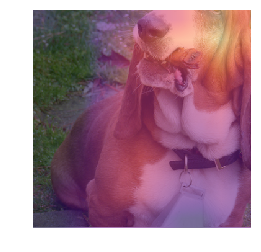

In [50]:
show_heatmap(avg_acts)

## Grad-CAM

In [51]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [53]:
mult = (acts * grad_chan[..., None, None]).mean(0)

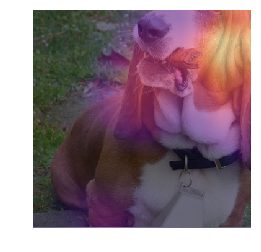

In [54]:
show_heatmap(mult)